In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm

In [2]:
setup_path ="/home/haue/repositories/Masters/setup/" 
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
twop_path = "/home/haue/repositories/Masters/data/twoproton/Al/"
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
twop_files = glob.glob(os.path.join(twop_path, "*mlio.root"))


frac = 0.9542011788469517 # (Na21/(p+Na21)) amount of energy the daughter nucleus gets of the total energy released in the decay
frac_err = 1.032071836027589e-10 # uncertainty of the fraction
psep = 5.50410 # proton separation energy of 22Mg
psep_err = 0.00016 # error of proton separation energy of 22Mg
bw = 0.01 # bin width to be used, 10 keV
scale = 3.326542500626603 # difference in solid angle coverage of two proton events up to 4pi
difference_in_method_error = 0.002 # 2 keV - error estimated from the choice of gauss fitting instead of peak finding using SearchHighRes()
sac4 = 6.795917343263473

In [3]:
E2 = np.array([]); fEdep = np.array([]); bEdep=np.array([])
for batch in uproot.iterate(Al_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    E2=np.append(E2, ak.flatten(batch.E))
    fEdep=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdep=np.append(bEdep, ak.flatten(batch.bEdep))
fEdep = np.nan_to_num(fEdep, nan=0.0)
bEdep = np.nan_to_num(bEdep, nan=0.0)
E2p = np.array([])
for batch in uproot.iterate(twop_files, expressions=["E"],
                            cut="(id==3)"):
    E2p=np.append(E2p, ak.flatten(batch.E))
bins = np.arange(1000, 9000+10, 10)
counts_E2, _ = np.histogram(E2, bins=bins)
counts_E2p, _ = np.histogram(E2p, bins=bins)

Es = counts_E2 - scale * counts_E2p
Es = np.maximum(Es, 0) 
E = np.repeat((bins[:-1] + 0.5 * (bins[1] - bins[0])),np.asarray(Es).astype(int))


In [25]:
us1, ts1 = np.histogram(E, bins=np.arange(0,9000+10,10))
us2, ts2 = np.histogram(E2, bins=np.arange(0,9000+10,10))
us3, ts3 = np.histogram(E2p, bins=np.arange(0,9000+10,10))
np.sum(us1), np.sum(us2), np.sum(us3)*scale, np.sum(us2)-np.sum(us1)

(27839, 33182, 5216.018640982514, 5343)

In [26]:
onep = (np.sum(us2)-np.sum(us3)*scale+11094.185366292064)*100/sac4
twop = ((np.sum(us3)*scale+370.67051832755544)*100/sac4)/2
g = 540019 # from Eg1, other value 529968
tot = g+twop+onep
print(f"Total number of single proton events in id3 accounted for region below 1MeV: {onep:.0f}")
print(f"Total number of two proton events in id3 accounted for region below 1MeV: {twop:.0f}")
print(f"Total proton events:  {twop+onep:.0f}")
print("Total 22Mg decayed events: ", 540019)
print(f"Percentage 22Mg: {g/tot*100:.0f}% - Percentage 1p: {onep/tot*100:.0f}% - Percentage 2p: {twop/tot*100:.0f}%")
## This is calculated with an underestimation of the amount of 1p counts since we cannot see the region below 280 keV from id2 and there is evidence of a prominent peak there

Total number of single proton events in id3 accounted for region below 1MeV: 574759
Total number of two proton events in id3 accounted for region below 1MeV: 41103
Total proton events:  615863
Total 22Mg decayed events:  540019
Percentage 22Mg: 47% - Percentage 1p: 50% - Percentage 2p: 4%


In [5]:

def cal_error(energy):
    betacut=1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    Emask = (bad_E>betacut)
    bad_E = bad_E[Emask]
    if energy>np.min(bad_E):
        raise ValueError(f"The energy in question falls within telescope deadzone no error correction to be deduced -> try energies above the zone: {np.max(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_x = (2*energy - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_x/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_x/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_x * front_err[i][2]) + \
                            (0.5 * uncal_x * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    
    return np.sqrt(total_variance/counter)/1e3





def pcal_error(fedep,bedep):
    betacut = 1000
    Elin = np.arange(0., 11000., 10.)
    sac = np.array([])
    SA = np.loadtxt("../twoproton/sam_21al_U4.dat")
    v, fEdepmax, Elow, Eupp, fEdeplow, Esplow = np.loadtxt("../twoproton/tdz_21al_U4.dat", unpack=True)
    for i in range(len(Elin)):
        val = 0.
        if Elin[i] < betacut:
    #            print(Elin[i])
            sac = np.append(sac, val)
        else:
                # do not include outermost strips
            for j in range(0+1, 16-1):
                for k in range(0+1, 16-1):
                    if Esplow[j*16 + k] < Elin[i] and Elin[i] < Eupp[j*16 + k]:
    #                         print(j, k, Elin[i])
                        pass
                    else:
                        val += SA[j, k]
            sac = np.append(sac, val)
    sac_ = 100*sac/(4*np.pi)
    sacmask = np.where(sac_<np.max(sac_))
    bad_E = Elin[sacmask]
    if fedep+bedep < np.min(bad_E)*0.95:
        #print(np.max(bad_E))
        raise ValueError(f"The energy in question falls below the telescope energy region -> try energies above the zone: {np.min(bad_E)} using pcal_error(fEdep,bEdep)")
    hh = np.loadtxt("U4calerrors.dat") # first 16 entries are the errors from the front side strips in rising order and the last 16 are the backside strips in rising order
    front_err = hh[:len(hh)//2]
    back_err = hh[len(hh)//2:] 

    SA = np.loadtxt("../twoproton/sam_21al_U4.dat") # first entry is front strip 1 and is equal to zero next entry is front strip 2 
    padcal_errs = np.loadtxt("P4calerrors.dat")
    padcal = np.loadtxt(setup_path+"P4mult.cal")
    cals = np.loadtxt(setup_path+"U4EE.cal")
    front_cal = cals[:len(hh)//2]
    back_cal = cals[len(hh)//2:]
    
    maxSA = np.max(SA)
    total_variance = 0
    counter = 0
    for i in range(16):
        for j in range(16):
            if i==0 or i==15 or j==0 or j==15:
                continue
            
            uncal_fedep = (2*fedep - (front_cal[i][0]+back_cal[j][0])) / (front_cal[i][1]+back_cal[j][1])
            
            variance = (0.5 * front_err[i][0])**2 + \
                            (uncal_fedep/2 * front_err[i][1])**2 + \
                            (0.5 * back_err[j][0])**2 + \
                            (uncal_fedep/2 * back_err[j][1])**2 + \
                            (0.5 * uncal_fedep * front_err[i][2]) + \
                            (0.5 * uncal_fedep * back_err[j][2])
            weighted_variance = variance*(SA[i][j]/maxSA)
            total_variance += weighted_variance
            
            counter+=1
    uncal_bedep = (bedep-padcal[0])/padcal[1]
    pad_var = (uncal_bedep**2 * padcal_errs[1]**2)+padcal_errs[0]**2
    return np.sqrt(total_variance/counter+pad_var)/1e3



In [17]:
####Helper function and function definitions used to fit and plot
# Two function to use for fitting, one that estimates the background a long with fitting the gauss and one that has a specified background between the first and last bin


def gausslin(x, a, x0, sigma, s, c):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + s*x+c
def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def counter(E, x_low, x_up, quiet=False, yscale='log'):
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low,x_up+bw,bw))
    counts = np.sum(ys)*scale
    counts_err = np.sqrt(np.sum(ys))*scale
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Counted region: {x_low}-{x_up}")
    return counts, counts_err

def GaussArea(x_low,x_up,mu,sigma):
    return norm.cdf(x_up, loc=mu, scale=sigma) - norm.cdf(x_low, loc=mu, scale=sigma)
    
def GaussArea_error(x_low, x_up, mu, sigma, err_mu, err_sigma, cov_mu_sigma=0.0):
    pdf_x1 = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x2 = norm.pdf(x_up, loc=mu, scale=sigma)
    df_dmu = pdf_x1 - pdf_x2

    df_dsigma = ((x_low - mu) / sigma) * pdf_x1 - ((x_up - mu) / sigma) * pdf_x2

    variance = (df_dmu**2 * err_mu**2) + \
               (df_dsigma**2 * err_sigma**2) + \
               (2 * df_dmu * df_dsigma * cov_mu_sigma)
               
    return np.sqrt(variance)


def FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac,
                          popt, pcov, x_low, x_up, bw):
    a, mu, sigma = popt[0], popt[1], popt[2]

    df_da = (sigma * np.sqrt(2 * np.pi)) / bw
    df_dsigma = (a * np.sqrt(2 * np.pi)) / bw

    pdf_x_low = norm.pdf(x_low, loc=mu, scale=sigma)
    pdf_x_up = norm.pdf(x_up, loc=mu, scale=sigma)
    
    dg_dmu = pdf_x_low - pdf_x_up
    dg_dsigma = ((x_low - mu) / sigma) * pdf_x_low - ((x_up - mu) / sigma) * pdf_x_up

  #Covariance between N and Nfrac
    cov_N_Nfrac = (df_da * dg_dmu * pcov[0, 1]) + \
                  (df_da * dg_dsigma * pcov[0, 2]) + \
                  (df_dsigma * dg_dmu * pcov[2, 1]) + \
                  (df_dsigma * dg_dsigma * pcov[2, 2])
    
    final_product = N * N_frac
    
    if final_product == 0:
        return 0.0

    relative_variance = (uncertainty_N / N)**2 + \
                        (uncertainty_N_frac / N_frac)**2 + \
                        2 * cov_N_Nfrac / (N * N_frac)

    if relative_variance < 0:
        relative_variance = 0

    final_error = abs(final_product) * np.sqrt(relative_variance)
    
    return final_error


def fixedlin_fit(E, x_low, x_up, gamma=0, quiet=False, yscale='log', deps = (None,None)):
     
    mean_fEdep = 0; mean_bEdep = 0
    if deps[0] is not None and deps[1] is not None:
        Emask = (E/1e3 >= x_low) & (E/1e3 <= x_up)
        fEdeps = deps[0][Emask]
        bEdeps = deps[1][Emask]
        mean_fEdep = np.mean(fEdeps)/1e3
        mean_bEdep = np.mean(bEdeps)/1e3
    
    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    x_bg = np.concatenate((xs[:1], xs[-1:]))
    y_bg = np.concatenate((ys[:1], ys[-1:]))

    s_fit, c_fit = np.polyfit(x_bg, y_bg, 1)

    func_fixed_bg = lambda x, a, x0, sigma: gausslin(x, a, x0, sigma, s_fit, c_fit)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = 0.02
    p0_final = [a_guess, x0_guess, sigma_guess]

    lower_bounds_final = [0, xs[0], 0]
    upper_bounds_final = [np.inf, xs[-1], np.inf]
    bounds_final = (lower_bounds_final, upper_bounds_final)

    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf

    popt_final, pcov_final = curve_fit(func_fixed_bg,xs,ys,p0=p0_final,sigma=errors,bounds=bounds_final)


    y_fit = func_fixed_bg(xs, *popt_final)
    residuals = ys - y_fit
    chi2 = np.sum((residuals / errors)**2)
    ndf = len(ys) - len(popt_final)
    chi2_red = chi2 / ndf if ndf > 0 else np.nan

    pcov_eff = pcov_final * chi2_red if np.isfinite(chi2_red) and (chi2_red > 1) else pcov_final


    final_parameters = [popt_final[0], popt_final[1], popt_final[2], s_fit, c_fit]

    var_mean = pcov_eff[1,1]
    mean = popt_final[1]
    
    N = (popt_final[0]*popt_final[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov_eff[0,0])/popt_final[0])**2 + (np.sqrt(pcov_eff[2,2])/popt_final[2])**2 + 2* pcov_eff[0,2] / (popt_final[0]*popt_final[2]))
    
    N_frac = GaussArea(x_low,x_up, popt_final[1],popt_final[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt_final[1], popt_final[2], np.sqrt(pcov_eff[1,1]), np.sqrt(pcov_eff[2,2]), pcov_eff[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt_final, pcov_eff, x_low, x_up, bw)
    
    N_background = np.sum(s_fit * xs + c_fit)
    x1, x2 = x_bg[0], x_bg[1]
    y1, y2 = y_bg[0], y_bg[1]
    var_y1 = y1
    var_y2 = y2
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    dx = x2 - x1
    dN_dy1 = (x2 * len_xs - sum_xs) / dx
    dN_dy2 = (sum_xs - x1 * len_xs) / dx
    var_N_background = (dN_dy1**2 * var_y1) + (dN_dy2**2 * var_y2)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N_peak + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N_peak**2 + uncertainty_N_background**2)

    xlin = np.linspace(xs[0]-bw*5, xs[-1]+5*bw, 200)

    try:
        calerr = cal_error(mean * 1e3)
        print("DSSSD error only used")
    except ValueError:
        try:
            calerr = np.sqrt(pcal_error(mean_fEdep,mean_bEdep)**2+cal_error(mean_fEdep)**2)
            print("pad error used")
        except ValueError:
            print("Some default value for the error is used due to errors lying in spurious zones")
            calerr = bw 

    error = np.sqrt(abs(var_mean)+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    
    if not quiet:
        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N_peak:.2f} ± {uncertainty_N_peak:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")
        print("="*50)
        print()
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.3,x_up+0.3+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.yscale(yscale)
        plt.plot(xlin, gausslin(xlin, *final_parameters), 'b-', label='Final Fit')
        plt.plot(xlin, s_fit * xlin + c_fit, 'g--', label='Background')

        plt.legend()
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit in range {x_low}-{x_up} + linear background taken from highest and lowest bin")
        
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': final_parameters,
        'covariance_matrix': pcov_final,

    }
    
    return results

def standard_fit(E, x_low, x_up, a_lowerbound=-np.inf, gamma=0, quiet=False, yscale='log', deps=(None,None)):
    mean_fEdep = 0; mean_bEdep = 0
    if deps[0] is not None and deps[1] is not None:        
        Emask = (E/1e3 >= x_low) & (E/1e3 <= x_up)
        fEdeps = deps[0][Emask]
        bEdeps = deps[1][Emask]
        mean_fEdep = np.mean(fEdeps)/1e3
        mean_bEdep = np.mean(bEdeps)/1e3    

    ys, xs = np.histogram(E/1e3, bins=np.arange(x_low, x_up+bw,bw))
    xs = np.array(xs[:-1])+bw/2
    ys = np.array(ys)

    a_guess = np.max(ys)
    x0_guess = xs[np.argmax(ys)]
    sigma_guess = (xs[-1] - xs[0]) * 0.1
    s_guess = 10
    c_guess = -100
    p0 = [a_guess, x0_guess, sigma_guess, s_guess, c_guess]
    lower_bounds = [0, xs[0], 0, a_lowerbound, -np.inf]
    upper_bounds = [np.inf, xs[-1], np.inf, np.inf, np.inf]
    bounds = (lower_bounds, upper_bounds)
    errors = np.sqrt(ys)
    errors[ys == 0] = np.inf
    popt, pcov = curve_fit(gausslin,xs,ys,p0=p0,sigma=errors,bounds=bounds,absolute_sigma=True)

    y_fit = gausslin(xs, *popt)
    residuals = ys - y_fit
    chi2 = np.sum((residuals / errors)**2)
    ndf = len(ys) - len(popt)
    chi2_red = chi2 / ndf if ndf > 0 else np.nan
    pcov_eff = pcov * chi2_red if np.isfinite(chi2_red) and (chi2_red > 1) else pcov

    xlin = np.linspace(x_low - 5*bw, x_up + 5*bw, 200)

    
    N = (popt[0]*popt[2]*np.sqrt(2*np.pi))/bw
    uncertainty_N = N*np.sqrt((np.sqrt(pcov_eff[0,0])/popt[0])**2 + (np.sqrt(pcov_eff[2,2])/popt[2])**2 + 2* pcov_eff[0,2] / (popt[0]*popt[2]))
    
    N_frac = GaussArea(x_low,x_up, popt[1],popt[2])
    uncertainty_N_frac= GaussArea_error(x_low,x_up,popt[1], popt[2], np.sqrt(pcov_eff[1,1]), np.sqrt(pcov_eff[2,2]), pcov_eff[1,2])
    
    
    N_peak = N*N_frac
    uncertainty_N_peak = FinalErr(N, uncertainty_N, N_frac, uncertainty_N_frac, popt, pcov_eff, x_low, x_up, bw)
    
    
    var_mean = pcov_eff[1,1]
    mean = popt[1]

    N_background = np.sum(popt[3] * xs + popt[4])
    var_s = pcov_eff[3, 3]
    var_c = pcov_eff[4, 4]
    cov_s_c = pcov_eff[3, 4]
    sum_xs = np.sum(xs)
    len_xs = len(xs)
    var_N_background = (sum_xs**2 * var_s) + (len_xs**2 * var_c) + (2 * sum_xs * len_xs * cov_s_c)
    uncertainty_N_background = np.sqrt(var_N_background)

    total_fitted_counts = N + N_background
    uncertainty_total_fitted = np.sqrt(uncertainty_N**2 + uncertainty_N_background**2)
    try:
        calerr = cal_error(mean * 1e3)
        print("DSSSD error only used")
    except ValueError:
        try:
            calerr = np.sqrt(pcal_error(mean_fEdep,mean_bEdep)**2+cal_error(mean_fEdep)**2)
            print("pad error used")
        except ValueError:
            print("Some default value for the error is used due to errors lying in spurious zones")
            calerr = bw
                
    error = np.sqrt(abs(var_mean)+calerr**2+difference_in_method_error**2)
    #if np.sqrt(var_mean)<cal_error(mean*1e3):
    #    mean_err = cal_error(mean*1e3)
    #else:
    #    mean_err = np.sqrt(var_mean)
    
    truepeak = 0
    if gamma==0:
        truepeak = mean/frac+psep
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==1:
        truepeak = mean/frac+psep+0.332
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==2:
        truepeak = mean/frac+psep+0.332+1.384
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    elif gamma==3:
        truepeak = mean/frac+psep+0.332+1.384+1.113
        truepeak_err = np.sqrt((error / frac)**2 + (mean * frac_err / frac**2)**2 + psep_err**2)
    else:
        raise ValueError(f"Invalid value for gamma: {gamma}. Expected 0, 1, 2, or 3.")
    if not quiet:
        plt.figure(figsize=(8,5))
        plt.hist(E/1e3, bins=np.arange(x_low-0.5,x_up+0.5+bw,bw), histtype='step', color='k', label="Full Data")
        plt.hist(E/1e3, bins=np.arange(x_low, x_up+bw,bw), histtype='step', color='r', label="Fit region")
        plt.plot(xlin, gausslin(xlin, popt[0], popt[1], popt[2], popt[3], popt[4]),'b-')

        print("--- Fit Values---")
        print(f"Peak Mean:                     {mean:.3f} ± {error:.3f}")# ({cal_error(mean*1e3):.3f})")
        print(f"22Mg excited level energy:     {truepeak:.3f} ± {truepeak_err:.3f}")
        print(f"Peak Counts:                   {N:.2f} ± {uncertainty_N:.2f}")
        print(f"Background Counts:             {N_background:.2f} ± {uncertainty_N_background:.2f}")
        print("-" * 50)
        print("--- Total ---")
        print(f"Total Fitted Counts (Peak+Bg): {total_fitted_counts:.2f} ± {uncertainty_total_fitted:.2f}")        
        plt.yscale(yscale)
        plt.xlabel("Energy(MeV)")
        plt.ylabel("Counts/10keV")
        plt.title(f"Gauss fit+linear background in range {x_low}-{x_up}")
        print("="*50)
        print()
    results = {
        'peak_counts': N_peak,
        'peak_counts_uncertainty': uncertainty_N_peak,
        'background_counts': N_background,
        'background_counts_uncertainty': uncertainty_N_background,
        'total_fitted_counts': total_fitted_counts,
        'total_fitted_uncertainty': uncertainty_total_fitted,
        'mean': mean,
        'mean_uncertainty': error,
        'truepeak': truepeak,
        'truepeak_uncertainty': truepeak_err,
        'fit_parameters': popt,
        'covariance_matrix': pcov
    }
    return results


DSSSD error only used
--- Fit Values---
Peak Mean:                     1.167 ± 0.003
22Mg excited level energy:     8.443 ± 0.003
Peak Counts:                   303.70 ± 37.67
Background Counts:             532.00 ± 46.13
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 835.70 ± 59.56

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.311 ± 0.003
22Mg excited level energy:     6.878 ± 0.003
Peak Counts:                   591.27 ± 75.41
Background Counts:             595.00 ± 45.63
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 1186.27 ± 88.14

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.249 ± 0.002
22Mg excited level energy:     7.145 ± 0.002
Peak Counts:                   9558.60 ± 346.93
Background Counts:             436.74 ± 247.23
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 9995.34 ± 

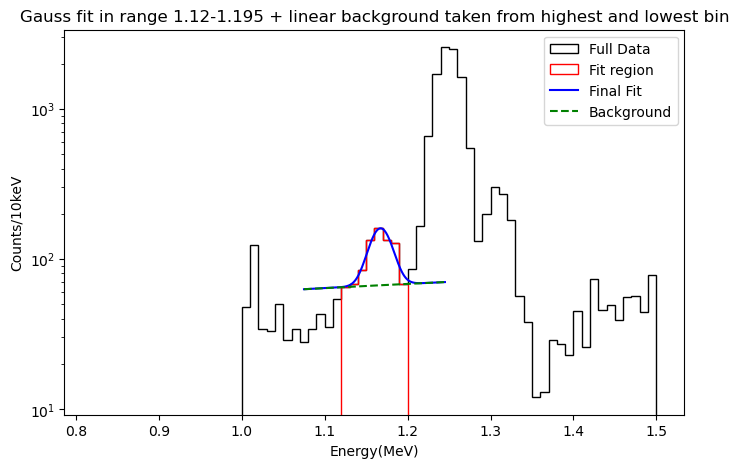

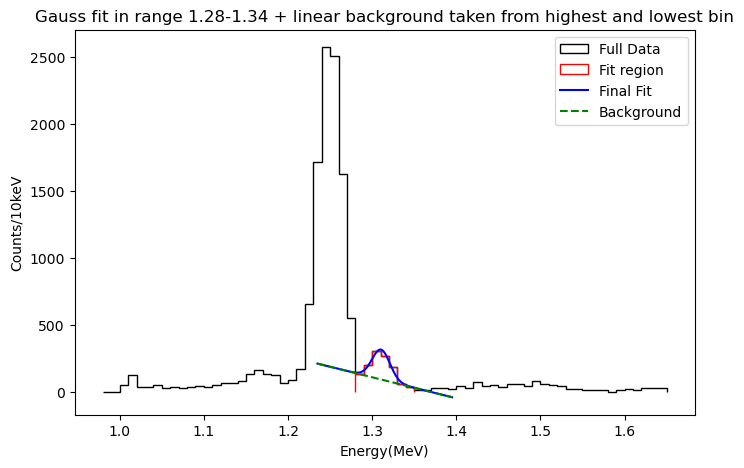

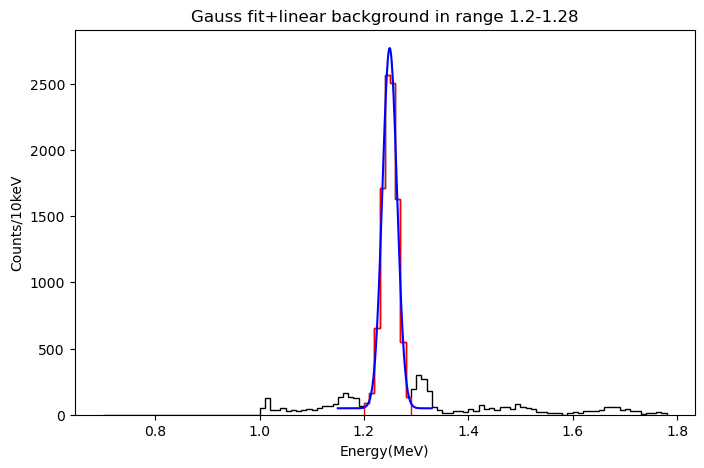

In [7]:
leftsat = fixedlin_fit(E, 1.12,1.195, gamma=2, quiet=False, yscale='log')
rightsat = fixedlin_fit(E, 1.28,1.34, gamma=0, quiet=False, yscale='linear')
main = standard_fit(E, 1.20, 1.28, a_lowerbound=0, gamma=1, quiet=False, yscale='linear')


leftsat_counts = leftsat['peak_counts']
leftsat_counts_err = np.sqrt(leftsat['peak_counts_uncertainty']**2)

rightsat_counts = rightsat['peak_counts']
rightsat_counts_err = np.sqrt(rightsat['peak_counts_uncertainty']**2)

main_counts = main['total_fitted_counts']+leftsat['background_counts']+rightsat['background_counts']
main_counts_err = np.sqrt(main['total_fitted_uncertainty']**2+leftsat['background_counts_uncertainty']**2+rightsat['background_counts_uncertainty']**2)

print(f"Total main peak counts corrected for 2p and satelite backgrounds: {main_counts:.0f} ± {main_counts_err:.0f} counts")
print(f"Total left satelite peak counts corrected for 2p: {leftsat_counts:.0f} ± {leftsat_counts_err:.0f} counts")
print(f"Total right satelite peak counts corrected for 2p: {rightsat_counts:.0f} ± {rightsat_counts_err:.0f} counts")
print()
print("="*100)
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {main['mean']:.3f} ± {main['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {main['truepeak']:.3f} ± {main['truepeak_uncertainty']:.3f}")
print()
print(f"left peak:")
print(f"Proton energies:            {leftsat['mean']:.3f} ± {leftsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {leftsat['truepeak']:.3f} ± {leftsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right peak:")
print(f"Proton energies:            {rightsat['mean']:.3f} ± {rightsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat['truepeak']:.3f} ± {rightsat['truepeak_uncertainty']:.3f}")
print()

DSSSD error only used
--- Fit Values---
Peak Mean:                     1.673 ± 0.005
22Mg excited level energy:     7.590 ± 0.005
Peak Counts:                   320.65 ± 66.80
Background Counts:             165.19 ± 68.64
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 485.84 ± 95.78

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.953 ± 0.004
22Mg excited level energy:     10.315 ± 0.004
Peak Counts:                   122.88 ± 41.45
Background Counts:             473.87 ± 48.72
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 596.75 ± 63.97

(3190.1542581009126, 103.01545380731774)
DSSSD error only used
--- Fit Values---
Peak Mean:                     4.351 ± 0.003
22Mg excited level energy:     10.395 ± 0.003
Peak Counts:                   211.96 ± 20.92
Background Counts:             252.00 ± 38.88
--------------------------------------------------
--- Total ---
To

(0.0, 100.0)

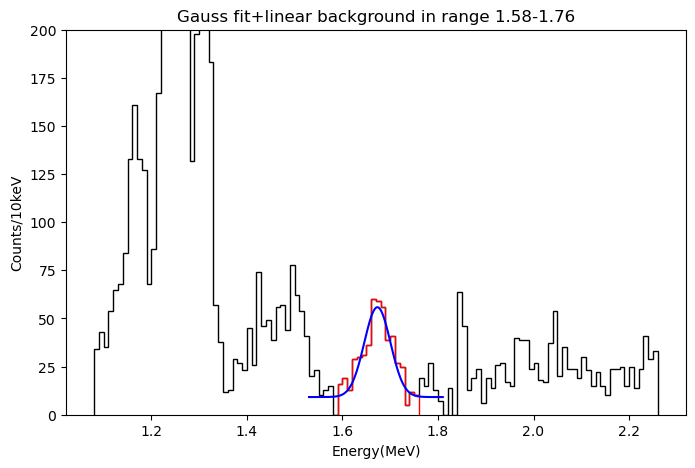

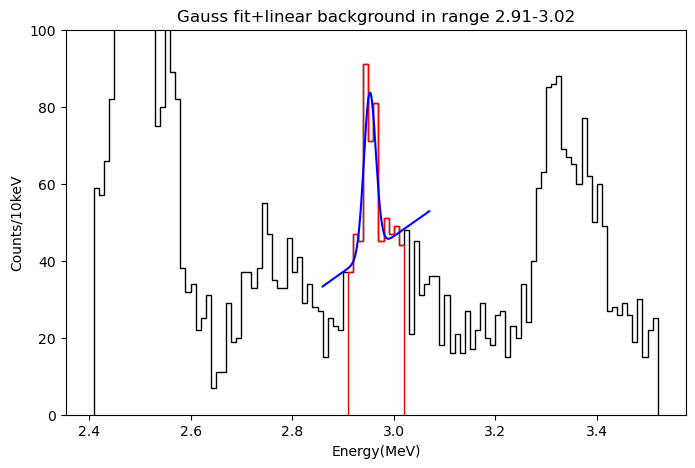

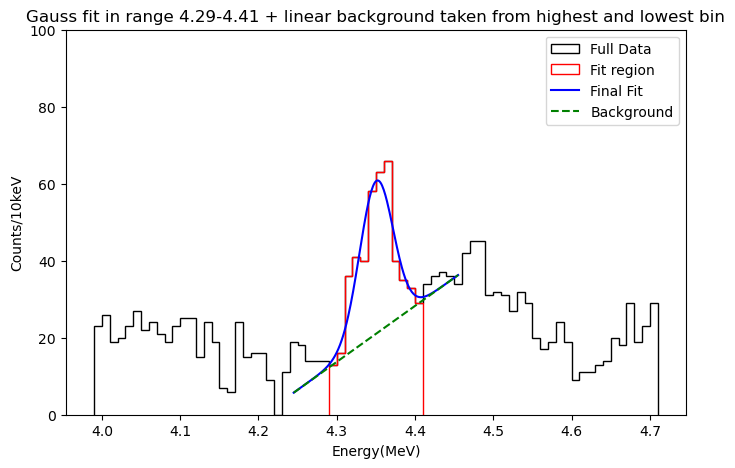

In [8]:
main = standard_fit(E, 1.58, 1.76, a_lowerbound=0, gamma=1, quiet=False, yscale='linear')
plt.ylim(0,200)
main2 = standard_fit(E, 2.91, 3.02, a_lowerbound=0, gamma=2, quiet=False, yscale='linear')
plt.ylim(0,100)
main2c = counter(E, 2.88,3.10, quiet=True, yscale='linear')
plt.ylim(0,100)
print(main2c)

main3 = fixedlin_fit(E, 4.29, 4.41, gamma=1, quiet=False, yscale='linear')
main3c = counter(E, 4.28,4.58, quiet=True, yscale='linear')

plt.ylim(0,100)

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.486 ± 0.002
22Mg excited level energy:     8.442 ± 0.002
Peak Counts:                   2299.80 ± 86.23
Background Counts:             706.95 ± 74.10
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 3006.75 ± 113.70

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.396 ± 0.003
22Mg excited level energy:     8.348 ± 0.003
Peak Counts:                   65.70 ± 7.32
Background Counts:             329.00 ± 33.93
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 394.70 ± 34.71

DSSSD error only used
--- Fit Values---
Peak Mean:                     2.563 ± 0.004
22Mg excited level energy:     9.906 ± 0.004
Peak Counts:                   128.59 ± 27.68
Background Counts:             339.00 ± 31.89
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 467.59 ± 42.2

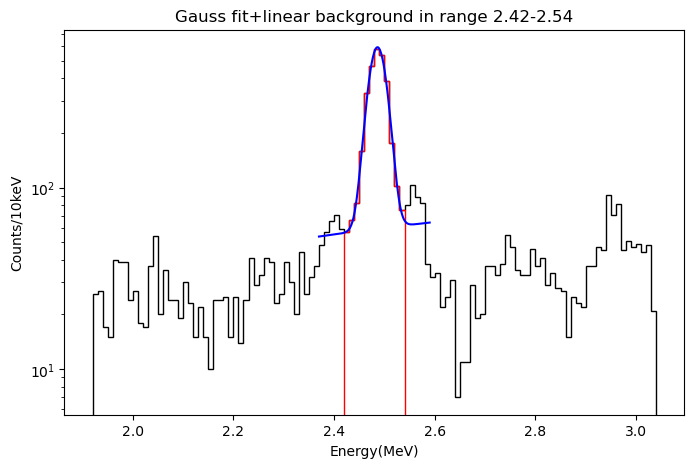

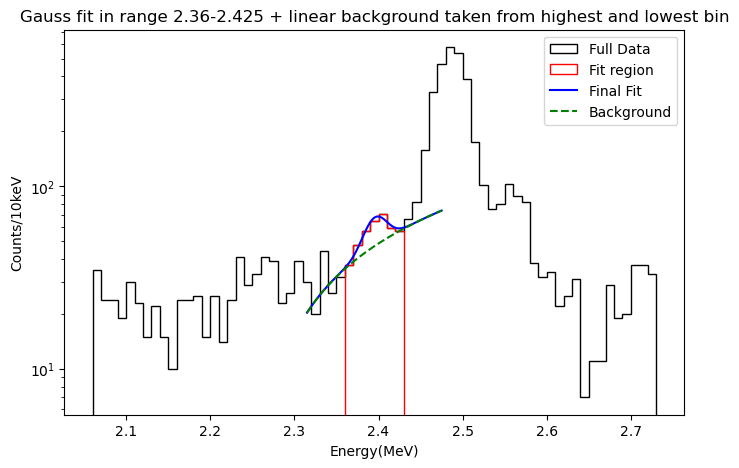

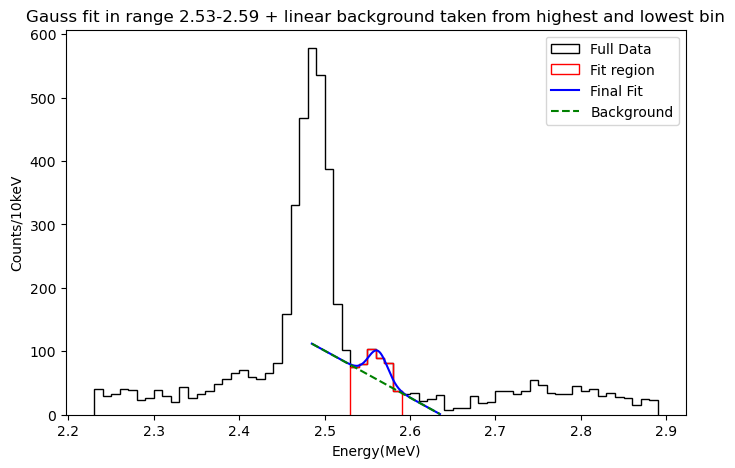

In [9]:

fifth = standard_fit(E, 2.42,2.54, gamma=1, quiet=False)

c = fifth['total_fitted_counts']
c_err = np.sqrt(fifth['total_fitted_uncertainty']**2)


leftsat = fixedlin_fit(E, 2.36,2.425, gamma=1, quiet=False, yscale='log')

rightsat = fixedlin_fit(E, 2.53,2.59, gamma=2, quiet=False, yscale='linear')


leftsat_counts = leftsat['peak_counts']
leftsat_counts_err = np.sqrt(leftsat['peak_counts_uncertainty']**2)
rightsat_counts = rightsat['peak_counts']
rightsat_counts_err = np.sqrt(rightsat['peak_counts_uncertainty']**2)


main_counts = fifth['total_fitted_counts']+leftsat['background_counts']+rightsat['background_counts']
main_counts_err = np.sqrt(fifth['total_fitted_uncertainty']**2+leftsat['background_counts_uncertainty']**2+rightsat['background_counts_uncertainty']**2)

print(f"Total main peak counts corrected for 2p and satelite backgrounds: {(main_counts+leftsat_counts):.0f} ± {np.sqrt(main_counts_err**2+leftsat_counts_err**2):.0f} counts")
print(f"Total right satelite peak counts corrected for 2p: {rightsat_counts:.0f} ± {rightsat_counts_err:.0f} counts")
print(f"Total left satelite peak counts corrected for 2p: {leftsat_counts:.0f} ± {leftsat_counts_err:.0f} counts")


print(f"The right2 & left peak has been subtracted from the main peak as there seems to a contribution from 2p events from the background")
print()
print("="*100)
print(f"Fitted means for the peaks and their true value")
print()
print(f"Main peak:")
print(f"Proton energies:            {fifth['mean']:.3f} ± {fifth['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {fifth['truepeak']:.3f} ± {fifth['truepeak_uncertainty']:.3f}")
print()
print(f"left peak:")
print(f"Proton energies:            {leftsat['mean']:.3f} ± {leftsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {leftsat['truepeak']:.3f} ± {leftsat['truepeak_uncertainty']:.3f}")
print()
print(f"Right peak:")
print(f"Proton energies:            {rightsat['mean']:.3f} ± {rightsat['mean_uncertainty']:.3f}")
print(f"22Mg excitedstate energies: {rightsat['truepeak']:.3f} ± {rightsat['truepeak_uncertainty']:.3f}")
print()


DSSSD error only used
--- Fit Values---
Peak Mean:                     5.456 ± 0.002
22Mg excited level energy:     14.051 ± 0.003
Peak Counts:                   142.39 ± 10.36
Background Counts:             93.50 ± 22.68
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 235.89 ± 24.93

DSSSD error only used
--- Fit Values---
Peak Mean:                     3.880 ± 0.005
22Mg excited level energy:     9.902 ± 0.005
Peak Counts:                   182.70 ± 41.97
Background Counts:             180.00 ± 26.83
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 362.70 ± 49.81


Peak in range 3.84-3.92:
Total counts sub 2p 362.70 ± 49.81



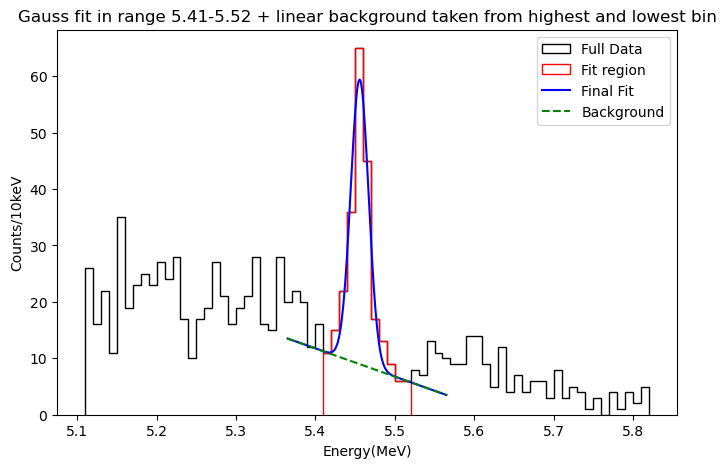

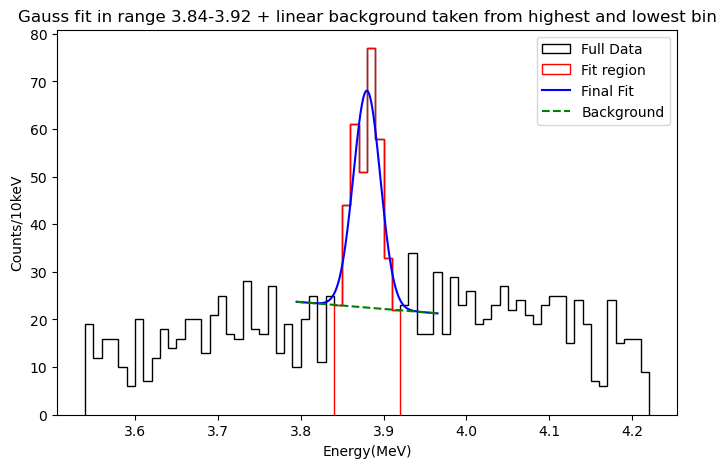

In [10]:
main = fixedlin_fit(E, 5.41, 5.52, gamma=3, quiet=False, yscale='linear')
main2 = fixedlin_fit(E, 3.84,3.92, gamma=1, yscale='linear')#, a_lowerbound=0)
main_counts = main2['total_fitted_counts']
main_counts_err = np.sqrt(main2['total_fitted_uncertainty']**2)
print("="*100)
print()
print(f"Peak in range 3.84-3.92:")
print(f"Total counts sub 2p {main_counts:.2f} ± {main_counts_err:.2f}")

print()

pad error used
--- Fit Values---
Peak Mean:                     6.521 ± 0.006
22Mg excited level energy:     14.054 ± 0.006
Peak Counts:                   96.95 ± 9.78
Background Counts:             15.00 ± 10.61
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 111.95 ± 14.43

pad error used
--- Fit Values---
Peak Mean:                     7.842 ± 0.006
22Mg excited level energy:     14.055 ± 0.006
Peak Counts:                   69.02 ± 7.64
Background Counts:             0.00 ± 0.00
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 69.02 ± 7.64



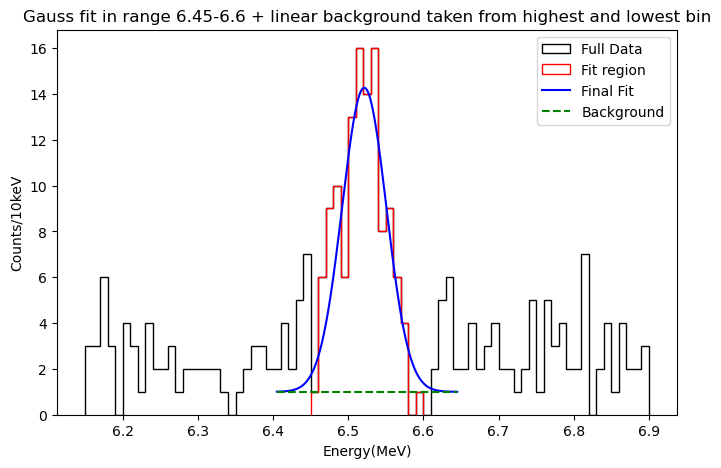

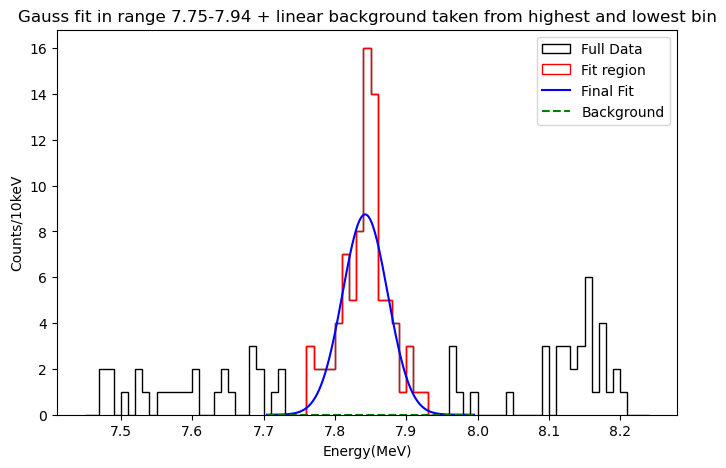

In [18]:
# overlapping satellite peak -> not usable for gaussian determination!
# low peak lies in spurious zone as well
main = fixedlin_fit(E, 6.45, 6.6, gamma=2, quiet=False, yscale='linear', deps=(fEdep,bEdep))

main = fixedlin_fit(E, 7.75, 7.94, gamma=1, quiet=False, yscale='linear', deps=(fEdep,bEdep))


In [19]:
################# from inside beta region

data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
Alb_files = glob.glob(os.path.join(data_path+"/exclbetacut/", "*mlio.root"))

Eb = np.array([]); fEdepb = np.array([]); bEdepb=np.array([])
for batch in uproot.iterate(Alb_files, expressions=["E", "fEdep", "bEdep"],
                            cut="(id==3)"):
    Eb=np.append(Eb, ak.flatten(batch.E))
    fEdepb=np.append(fEdep, ak.flatten(batch.fEdep))
    bEdepb=np.append(bEdep, ak.flatten(batch.bEdep))
    

DSSSD error only used
--- Fit Values---
Peak Mean:                     0.994 ± 0.002
22Mg excited level energy:     6.878 ± 0.002
Peak Counts:                   1400.15 ± 99.88
Background Counts:             592.00 ± 48.66
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 1992.15 ± 111.10

DSSSD error only used
--- Fit Values---
Peak Mean:                     0.931 ± 0.002
22Mg excited level energy:     9.309 ± 0.002
Peak Counts:                   136.96 ± 8.22
Background Counts:             531.00 ± 39.91
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 667.96 ± 40.75

DSSSD error only used
--- Fit Values---
Peak Mean:                     0.772 ± 0.003
22Mg excited level energy:     6.313 ± 0.003
Peak Counts:                   132.98 ± 23.62
Background Counts:             822.00 ± 49.66
--------------------------------------------------
--- Total ---
Total Fitted Counts (Peak+Bg): 954.98 ± 54.

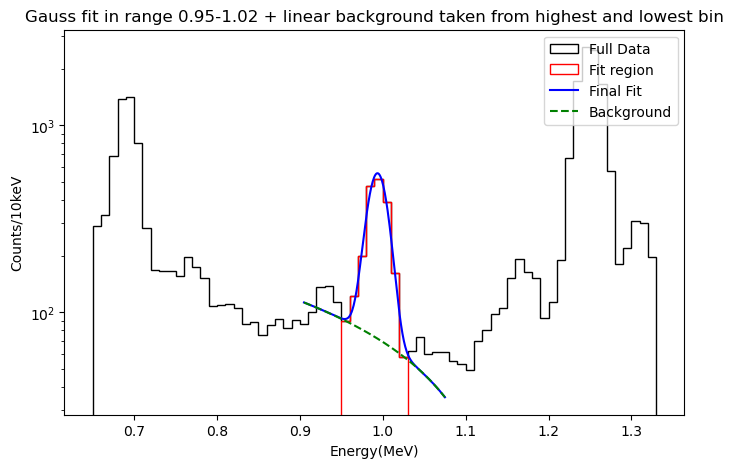

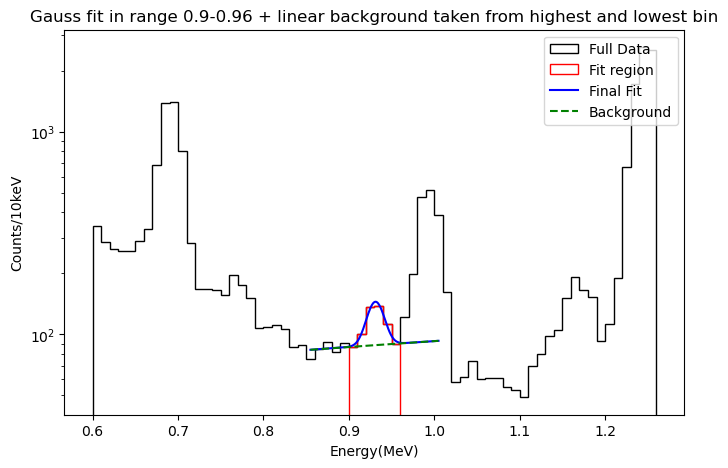

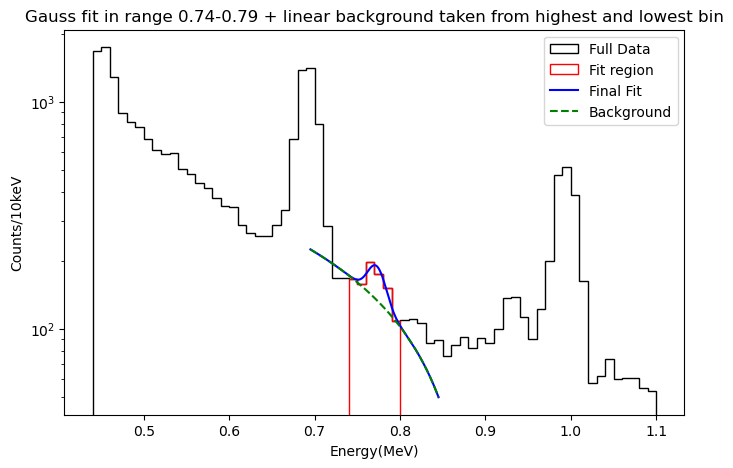

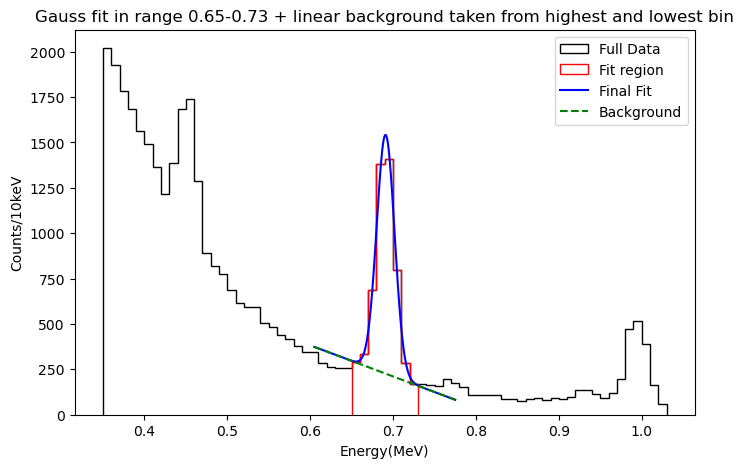

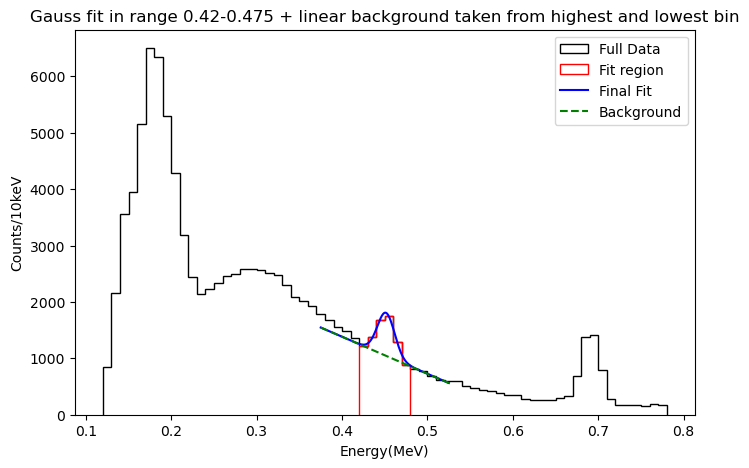

In [20]:
main = fixedlin_fit(Eb, 0.95, 1.02, gamma=1, quiet=False, yscale='log')
main1 = fixedlin_fit(Eb, 0.9, 0.96, gamma=3, quiet=False, yscale='log')
main2 = fixedlin_fit(Eb, 0.74, 0.79, gamma=0, quiet=False, yscale='log')
main3 = fixedlin_fit(Eb, 0.65, 0.73, gamma=0, quiet=False, yscale='linear')
main4 = fixedlin_fit(Eb, 0.42, 0.475, gamma=1, quiet=False, yscale='linear')